In [1]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [2]:
def load_datasets(directory):
    image_paths = []
    labels = []
    for label in os.listdir(directory):
        for filename in os.listdir(os.path.join(directory, label)):
            image_paths.append(os.path.join(directory, label, filename))
            labels.append(label)
    return image_paths, labels

train_directory = '../data/train/'
test_directory = '../data/test/'



In [3]:
train = pd.DataFrame()
train['image'], train['label'] = load_datasets(train_directory)
train = train.sample(frac=1).reset_index(drop=True)

test = pd.DataFrame()
test['image'], test['label'] = load_datasets(test_directory)
test = test.sample(frac=1).reset_index(drop=True)

In [4]:
transform = transforms.Compose([
    transforms.Grayscale(),       
    transforms.Resize((48, 48)),  
    transforms.ToTensor(),        
    transforms.Normalize((0.5,), (0.5,))  
])


In [5]:
def extract_features(image_paths):
    features = []
    for path in image_paths:
        img = Image.open(path).convert('RGB')
        img = transform(img)
        features.append(img)
    return torch.stack(features)

train_features = extract_features(train['image'])
test_features = extract_features(test['image'])

x_train = train_features
x_test = test_features


In [6]:
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

In [7]:
class MyModel(nn.Module):
    def __init__(self, num_classes):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.4)

        self.flatten_dim = 512 * 3 * 3  
        self.fc1 = nn.Linear(self.flatten_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


        



In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MyModel(num_classes=7).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [9]:
train_losses = []
test_accuracies = []

for epoch in range(1, 51):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

    print(f'Epoch [{epoch}/50], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')


Epoch [1/50], Loss: 1.7148, Accuracy: 36.03%
Epoch [2/50], Loss: 1.3964, Accuracy: 51.95%
Epoch [3/50], Loss: 1.2702, Accuracy: 52.81%
Epoch [4/50], Loss: 1.1890, Accuracy: 54.92%
Epoch [5/50], Loss: 1.1123, Accuracy: 56.87%
Epoch [6/50], Loss: 1.0587, Accuracy: 56.94%
Epoch [7/50], Loss: 0.9910, Accuracy: 55.42%
Epoch [8/50], Loss: 0.9259, Accuracy: 58.90%
Epoch [9/50], Loss: 0.8583, Accuracy: 59.40%
Epoch [10/50], Loss: 0.7921, Accuracy: 59.14%
Epoch [11/50], Loss: 0.7204, Accuracy: 61.66%
Epoch [12/50], Loss: 0.6457, Accuracy: 60.87%
Epoch [13/50], Loss: 0.5732, Accuracy: 55.82%
Epoch [14/50], Loss: 0.5119, Accuracy: 59.45%
Epoch [15/50], Loss: 0.4498, Accuracy: 58.67%
Epoch [16/50], Loss: 0.3917, Accuracy: 54.32%
Epoch [17/50], Loss: 0.3511, Accuracy: 59.43%
Epoch [18/50], Loss: 0.3104, Accuracy: 60.24%
Epoch [19/50], Loss: 0.2705, Accuracy: 60.38%
Epoch [20/50], Loss: 0.2484, Accuracy: 58.41%
Epoch [21/50], Loss: 0.2157, Accuracy: 59.52%
Epoch [22/50], Loss: 0.1898, Accuracy: 60.4

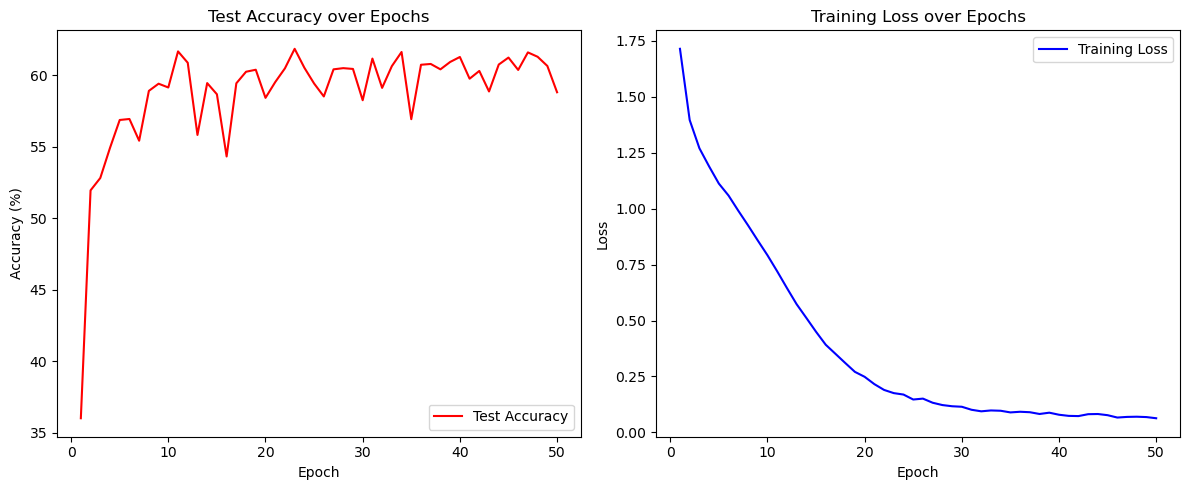

In [10]:
import matplotlib.pyplot as plt

epochs = range(1, 51)

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs, test_accuracies, 'r', label='Test Accuracy')
plt.title('Test Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, 'b', label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


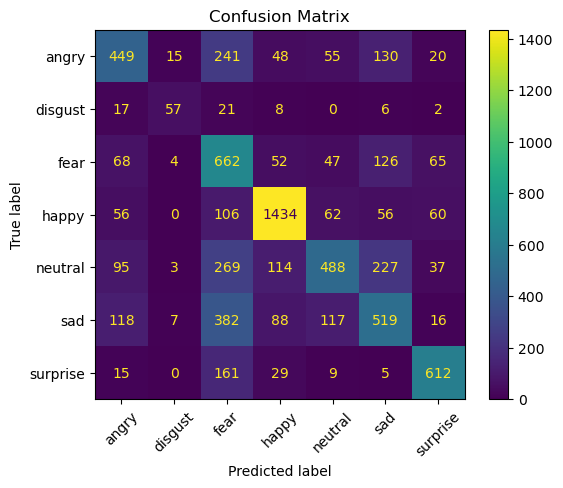

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()
